<a href="https://colab.research.google.com/github/etalab-ia/ami-ia/blob/master/notebooks/intro-ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction à l'apprentissage supervisé

Une introduction au *machine learning* avec l'examples des données de contrôles sanitaires de la direction générale de l'alimentation : https://www.data.gouv.fr/fr/datasets/resultats-des-controles-officiels-sanitaires-dispositif-dinformation-alimconfiance/.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

%matplotlib inline

## 1. Importation et exploration des données

### Importer un jeu de données

Grâce à la librairie pandas. Par exemple, depuis internet.


In [0]:
df = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/fff0cc27-977b-40d5-9c11-f7e4e79a0b72', sep=';')

Quelle est la taille de mes données ?

In [3]:
df.shape

(38102, 13)

### A quoi ressemble mon jeu de données ?


In [4]:
df.head(5)

,APP_Libelle_etablissement,SIRET,Code_postal,Libelle_commune,Numero_inspection,Date_inspection,APP_Libelle_activite_etablissement,Synthese_eval_sanit,Agrement,geores,filtre,ods_adresse,ods_type_activite
0,LE GAULOIS,84752155600013,13100.0,AIX EN PROVENCE,2,2019-05-22T13:00:00+02:00,Restaurant,Très satisfaisant,NaN,"43.531956,5.4468",Restaurant,34 rue Jacques de la Roque,Autres
1,LE CARDEUR DE BACCHUS,82183401700013,13100.0,AIX EN PROVENCE,3,2019-05-24T13:30:00+02:00,Restaurant,Très satisfaisant,NaN,"43.529969,5.446457",Restaurant,14 Forum des cardeurs,Autres
2,CARREFOUR BAR,40829886700016,13100.0,AIX EN PROVENCE,6,2019-05-21T12:30:00+02:00,Restaurant,Très satisfaisant,NaN,"43.525265,5.453713",Restaurant,2 rue Roux Alpherand,Autres
3,LES FILS A MAMAN,83283779300021,13100.0,AIX EN PROVENCE,0,2019-06-13T13:45:00+02:00,Restaurant,Très satisfaisant,NaN,"43.528498,5.447157",Restaurant,42 rue Verrerie,Autres
4,LE FOURNIL DES CORDELIERS,48466238200023,13100.0,AIX EN PROVENCE,1,2019-06-07T11:30:00+02:00,Boulangerie-Pâtisserie,Très satisfaisant,NaN,"43.52948,5.444981",Boulangerie-Pâtisserie,67 rue des Cordeliers,Autres


Et un échantillon aléatoire ?


In [5]:
df.sample(5)

,APP_Libelle_etablissement,SIRET,Code_postal,Libelle_commune,Numero_inspection,Date_inspection,APP_Libelle_activite_etablissement,Synthese_eval_sanit,Agrement,geores,filtre,ods_adresse,ods_type_activite
26474,ECOLE MATERNELLE,21750001600274,75013.0,Paris 13e Arrondissement,20-022335-1,2020-03-05T01:00:00+01:00,Restauration collective,Satisfaisant,75113016,"48.83056,2.368114",Restauration collective,32 PLACE JEANNE D ARC,Autres
22408,PIZZA TIME,84042157200016,94000.0,Créteil,19-049415-1,2019-06-03T02:00:00+02:00,Restaurant,Très satisfaisant,NaN,"48.785515,2.43646",Restaurant,126 AVENUE DU MARECHAL FOCH,Autres
12847,CAT,78056876200113,60120.0,Breteuil,20-004263-1,2020-01-22T01:00:00+01:00,Restauration collective,Très satisfaisant,NaN,"49.630373,2.315006",Restauration collective,RUE BLERIOT,Autres
2661,CHARCUTERIE ADER,32457903600041,65220.0,Trie-sur-Baïse,19-010764-1,2019-10-14T02:00:00+02:00,Transformation de produits carnés,Très satisfaisant,65452001,"43.316072,0.365554",NaN,RTE DE TARBES,Viandes et produits carnés
10042,AC MONTPARNASSE,31599850000013,75015.0,Paris 15e Arrondissement,20-003467-1,2020-01-15T01:00:00+01:00,Restaurant,Satisfaisant,NaN,"48.842583,2.320459",Restaurant,32 AVENUE DU MAINE,Autres


Quels types de données ?


In [6]:
df.dtypes

APP_Libelle_etablissement              object
SIRET                                  object
Code_postal                           float64
Libelle_commune                        object
Numero_inspection                      object
Date_inspection                        object
APP_Libelle_activite_etablissement     object
Synthese_eval_sanit                    object
Agrement                               object
geores                                 object
filtre                                 object
ods_adresse                            object
ods_type_activite                      object
dtype: object

### Explorer le contenu de chaque colonne

Quels résultats pour les contrôles ?

In [7]:
df['Synthese_eval_sanit'].value_counts()

Satisfaisant                     19845
Très satisfaisant                15515
A améliorer                       2611
A corriger de manière urgente      131
Name: Synthese_eval_sanit, dtype: int64

Quels types d'établissements ?

In [8]:
df['filtre'].value_counts()

Restaurant                                                                                        14572
Restauration collective                                                                            6368
Boucherie-Charcuterie                                                                              1504
Boulangerie-Pâtisserie                                                                             1039
Alimentation générale                                                                               926
                                                                                                  ...  
Chocolatier|Glacier                                                                                   1
Boucherie-Charcuterie|Fromagerie|Poissonnerie|Traiteur                                                1
Chocolatier|Traiteur                                                                                  1
Fromagerie|Poissonnerie                                         

Certaines établissements appartiennent à plusieurs types, mais quelle proportion ?

In [9]:
(df['filtre'].str.contains('\|')).sum() / len(df)

0.014749881895963466

On fait le choix (arbitraire) de ne garder que le premier

In [0]:
df['filtre'] = df['filtre'].str.split('\|').str[0]

Parfois certaines colonnes nécessitent une expertise métier...

In [11]:
df['APP_Libelle_activite_etablissement'].value_counts()

Restaurant                                                                                           14572
Restauration collective                                                                               6368
Producteur fermier                                                                                    1769
Transformation de lait ou produits laitiers                                                           1340
Boucherie-Charcuterie                                                                                 1230
                                                                                                     ...  
Boucherie-Charcuterie|Fromagerie|Glacier|Poissonnerie                                                    1
Chocolatier|Glacier|Traiteur                                                                             1
Rayon boucherie-charcuterie|Rayon pain/viennoiserie/pâtisserie|Rayon fromagerie|Rayon traiteur           1
Boucherie-Charcuterie|Boulangerie-Pât

In [0]:
df.drop('APP_Libelle_activite_etablissement', axis=1, inplace=True)

Et à quoi correspond la colonne `ods_type_activite` ?


In [13]:
df['ods_type_activite'].value_counts()

Autres                                              29330
Viandes et produits carnés                           2649
Produits de la mer et d'eau douce                    1766
Lait et produits laitiers                            1570
Abattoirs                                            1431
Transport et entreposage de denrées alimentaires      995
Œufs et ovoproduits                                   361
Name: ods_type_activite, dtype: int64

Où se situent les contrôles ?

In [14]:
df['latitude'] = df['geores'].str.split(',').str[0].astype(float)
df['longitude'] = df['geores'].str.split(',').str[1].astype(float)
df.sample(1)

,APP_Libelle_etablissement,SIRET,Code_postal,Libelle_commune,Numero_inspection,Date_inspection,Synthese_eval_sanit,Agrement,geores,filtre,ods_adresse,ods_type_activite,latitude,longitude
11899,EHPAD LES SCEVOLLES,35200376800012,86420.0,Monts-sur-Guesnes,19-000500-1,2019-05-28T02:00:00+02:00,Satisfaisant,NaN,"46.915427,0.20593",Restauration collective,"1, Allée des Quatre Tilleuls",Autres,46.915427,0.20593


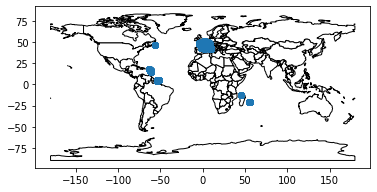

In [15]:
# !pip install geopandas
import geopandas
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
base = world.plot(color='white', edgecolor='black')
gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df['longitude'], df['latitude']))
gdf.plot(ax=base)

Exploration de l'étrange colonne `Agrement`

In [16]:
df['Agrement'].count() / len(df['Agrement'])

0.2352369954333106

## 2. Feature engineering

Le feature engineerng consiste choisir quelles features conserver, en ajouter de nouvelles, et les transformer sous un format adapté pour l'entraînement des modèles. Contrairement à ce qu'on peut penser, **c'est la phase la plus complexe et la plus longue.**

A garder en tête : les algorithmes d'apprentissage, supervisés ou non, **ne savent travailler qu'avec des données numériques.**

#### Simplifions notre valeur cible sous un format numérique

In [17]:
simplification = {'Très satisfaisant': 1,
                  'Satisfaisant': 1,
                  'A améliorer': 0,
                  'A corriger de manière urgente': 0}
df['Synthese_eval_sanit'] = df['Synthese_eval_sanit'].map(simplification)
df['Synthese_eval_sanit'].value_counts()

1    35360
0     2742
Name: Synthese_eval_sanit, dtype: int64

Géographiquement ça donne quoi ?

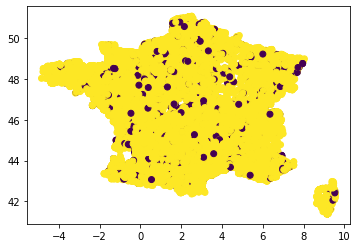

In [18]:
gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df['longitude'], df['latitude']))
gdf = gdf[(abs(gdf['longitude']) < 30) & (abs(gdf['latitude']) > 30)]
gdf.plot(column='Synthese_eval_sanit')

### Créer de nouvelles features

Utilisons l'agrément comme un marqueur de qualité

In [19]:
df['has_agrement'] = pd.notnull(df['Agrement']).astype(int)
df['has_agrement'].sample(1)

35936    0
Name: has_agrement, dtype: int64

Ne serait-il pas possible de prendre en compte les contrôles passés d'un restaurant ?

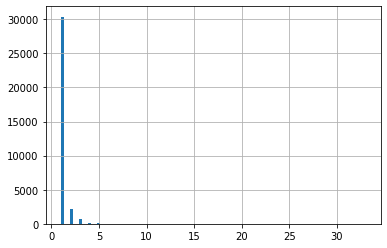

In [20]:
df['SIRET'].value_counts().hist(bins=100)

In [0]:
df['count_controls_siret'] = df.groupby('SIRET')['Synthese_eval_sanit'].transform(lambda x: x.count())

On peut aussi utiliser de l'information géographique, mais le niveau du code postal est trop précis.

Prenons plutôt les codes des départements.

In [22]:
df['Code_postal'].nunique()

5221

In [23]:
sum(df['Code_postal'].isnull())

24

In [24]:
df = df[df['Code_postal'].notnull()]
df['dept'] = np.floor(df['Code_postal'] / 1000)
df['dept'].sample(1)

23649    75.0
Name: dept, dtype: float64

On dispose de la date d'inspection : on peut donc en tirer de nouvelles features.

In [25]:
df['Date_inspection'].sample(1)

22941    2019-06-19T02:00:00+02:00
Name: Date_inspection, dtype: object

In [26]:
df['Date_inspection'] = pd.to_datetime(df['Date_inspection'], format='%Y-%m-%dT%H:%M:%S', utc=True)
df['Date_inspection'].sample(1)

12090   2019-08-02 00:00:00+00:00
Name: Date_inspection, dtype: datetime64[ns, UTC]

In [0]:
df['year'] = df['Date_inspection'].dt.year
df['month'] = df['Date_inspection'].dt.month
df['weekday'] = df['Date_inspection'].dt.weekday

Peut-on utiliser des informations transverses à plusieurs zones ou groupes ?

- Par département

In [0]:
df['count_controls_dept'] = df.groupby('dept')['Synthese_eval_sanit'].transform(lambda x: x.count())
df['score_controls_dept'] = df.groupby('dept')['Synthese_eval_sanit'].transform(lambda x: x.mean())

- Par secteur d'activité (Restaurant, Boucherie-Charcuterie, Boulangerie-Pâtisserie, etc.)

In [0]:
df['filtre'] = df['filtre'].fillna('NA')
df['count_controls_filtre'] = df.groupby('filtre')['Synthese_eval_sanit'].transform(lambda x: x.count())
df['score_controls_filtre'] = df.groupby('filtre')['Synthese_eval_sanit'].transform(lambda x: x.mean())

- Par type de produits vendus (Viandes et produits carnés, 
Produits de la mer et d'eau douce, Lait et produits laitiers, etc.)

In [0]:
df['ods_type_activite'] = df['ods_type_activite'].fillna('NA')
df['count_controls_activite'] = df.groupby('ods_type_activite')['Synthese_eval_sanit'].transform(lambda x: x.count())
df['score_controls_activite'] = df.groupby('ods_type_activite')['Synthese_eval_sanit'].transform(lambda x: x.mean())

- Par jour de la semaine !

In [0]:
df['count_controls_wday'] = df.groupby('weekday')['Synthese_eval_sanit'].transform(lambda x: x.count())
df['score_controls_wday'] = df.groupby('weekday')['Synthese_eval_sanit'].transform(lambda x: x.mean())

A quoi ressemblent nos ajouts ?

In [32]:
df.sample(1)

,APP_Libelle_etablissement,SIRET,Code_postal,Libelle_commune,Numero_inspection,Date_inspection,Synthese_eval_sanit,Agrement,geores,filtre,ods_adresse,ods_type_activite,latitude,longitude,geometry,has_agrement,count_controls_siret,dept,year,month,weekday,count_controls_dept,score_controls_dept,count_controls_filtre,score_controls_filtre,count_controls_activite,score_controls_activite,count_controls_wday,score_controls_wday
12284,PROXI SAINT MICHEL,79948733500025,75014.0,Paris 14e Arrondissement,20-025189-1,2020-03-13 00:00:00+00:00,1,NaN,"48.841585,2.330229",Alimentation générale,114 BOULEVARD DU MONTPARNASSE,Autres,48.841585,2.330229,POINT (2.33023 48.84159),0,1,75.0,2020,3,4,5874,0.964079,926,0.904968,29313,0.921025,5514,0.927276


### Supprimer des features inutiles ou inutilisables

In [0]:
drop_cols = ['APP_Libelle_etablissement', 'Code_postal', 'SIRET', 'Libelle_commune',
             'Numero_inspection', 'Date_inspection','Agrement', 'geores',
             'ods_adresse', 'geometry']
df = df.drop(drop_cols, axis=1)

### Encoder les colonnes catégorielles

Il est nécessaire de transformer les catégories en nombres. Mais comment faire ?

| Etablissement | Activité           |
| :------ | :-------------     | 
| A       | Restaurant         |
| B       | Producteur Fermier |
| C       | Boucherie          |
| D       | Restaurant         |

devient :

| Etablissement | Activité_Restaurant | Activité_ProducteurFermier | Activité_Boucherie |
| :------ | :-: | :-: | :-: | 
| A       | 1 | 0 | 0 |
| B       | 0 | 1 | 0 |
| C       | 0 | 0 | 1 |
| D       | 1 | 0 | 0 |


- **Etape 1 :** on transforme les features à encoder sous format de catégories

In [34]:
categorical_features = ['dept', 'filtre', 'ods_type_activite', 'month', 'weekday']
for c in categorical_features:
  df[c] = df[c].astype('category').cat.codes
  print('Nombre de catégories de la colonne "{}" : {}'.format(c, df[c].nunique()))
df.sample(1)

Nombre de catégories de la colonne "dept" : 97
Nombre de catégories de la colonne "filtre" : 19
Nombre de catégories de la colonne "ods_type_activite" : 7
Nombre de catégories de la colonne "month" : 12
Nombre de catégories de la colonne "weekday" : 7


,Synthese_eval_sanit,filtre,ods_type_activite,latitude,longitude,has_agrement,count_controls_siret,dept,year,month,weekday,count_controls_dept,score_controls_dept,count_controls_filtre,score_controls_filtre,count_controls_activite,score_controls_activite,count_controls_wday,score_controls_wday
27703,1,7,3,14.626751,-61.11267,1,1,95,2019,9,2,999,0.813814,10526,0.942428,1765,0.964873,7680,0.924219


- **Etape 2 :** on créer un encodeur, qui va directement transformer toutes les colonnes catégorielles

In [0]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse=False).fit(df[categorical_features])

- **Etape 3 :** on fusionne les encodages avec le dataframe originel

In [36]:
df = pd.concat([df,
                pd.DataFrame(data=encoder.transform(df[categorical_features]), 
                             columns=encoder.get_feature_names(categorical_features), 
                             index=df.index)], axis=1)
df.shape

(38078, 156)

In [37]:
df.sample(1)

,Synthese_eval_sanit,filtre,ods_type_activite,latitude,longitude,has_agrement,count_controls_siret,dept,year,month,weekday,count_controls_dept,score_controls_dept,count_controls_filtre,score_controls_filtre,count_controls_activite,score_controls_activite,count_controls_wday,score_controls_wday,dept_1,dept_2,dept_3,dept_4,dept_5,dept_6,dept_7,dept_8,dept_9,dept_10,dept_11,dept_12,dept_13,dept_14,dept_15,dept_16,dept_17,dept_18,dept_19,dept_20,dept_21,...,filtre_2,filtre_3,filtre_4,filtre_5,filtre_6,filtre_7,filtre_8,filtre_9,filtre_10,filtre_11,filtre_12,filtre_13,filtre_14,filtre_15,filtre_16,filtre_17,filtre_18,ods_type_activite_1,ods_type_activite_2,ods_type_activite_3,ods_type_activite_4,ods_type_activite_5,ods_type_activite_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
11339,1,6,1,46.573515,5.959589,0,1,38,2019,7,1,151,0.966887,467,0.970021,29313,0.921025,10149,0.92817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## 3. Entraîner et comparer des modèles

Une fois que nos données sont sélectionnées et mises en forme, la phase d'apprentissage consiste à choisir le modèle et à optimiser ses paramètres.

### Un dernier nettoyage du jeu de données

In [38]:
df.shape

(38078, 156)

Suppression des lignes contenant des NaN

In [39]:
df = df.dropna()
df.shape

(36933, 156)

Suppression des colonnes avec une seule valeur différente

In [40]:
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col, inplace=True, axis=1)
df.shape

(36933, 155)

### Séparation en jeux de données "train" et "test"

In [0]:
from sklearn.model_selection import train_test_split
features = [col for col in df.columns if col not in categorical_features
            and col != 'Synthese_eval_sanit']

df_train, df_test = train_test_split(df, test_size=0.2)

X_train = df_train[features]
y_train = df_train['Synthese_eval_sanit']

X_test = df_test[features]
y_test = df_test['Synthese_eval_sanit']

### Echantillonner pour équilibrer les classes


In [42]:
y_train.mean(), y_test.mean()

(0.9286197793271509, 0.927710843373494)

Les deux catégories que nous cherchons à prédire ne sont pas équilibrées ! L'algorithme pourrait utiliser cette faille pour facilement obtenir de bons résultats.

In [43]:
from imblearn.under_sampling import RandomUnderSampler
sampler = RandomUnderSampler()
X_train, y_train = sampler.fit_resample(X_train, y_train)
X_test, y_test = sampler.fit_resample(X_test, y_test)

y_train.mean(), y_test.mean()

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

(0.5, 0.5)

### Un modèle simple : la méthode des k plus proches voisins

In [44]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_model.score(X_test, y_test)

0.5955056179775281

### Un modèle plus avancé : l'arbre de décision

In [45]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(max_depth=10)
dt_model.fit(X_train, y_train)
dt_model.score(X_test, y_test)

0.6479400749063671

L'arbre de décision présente l'intérêt d'être interprétable :

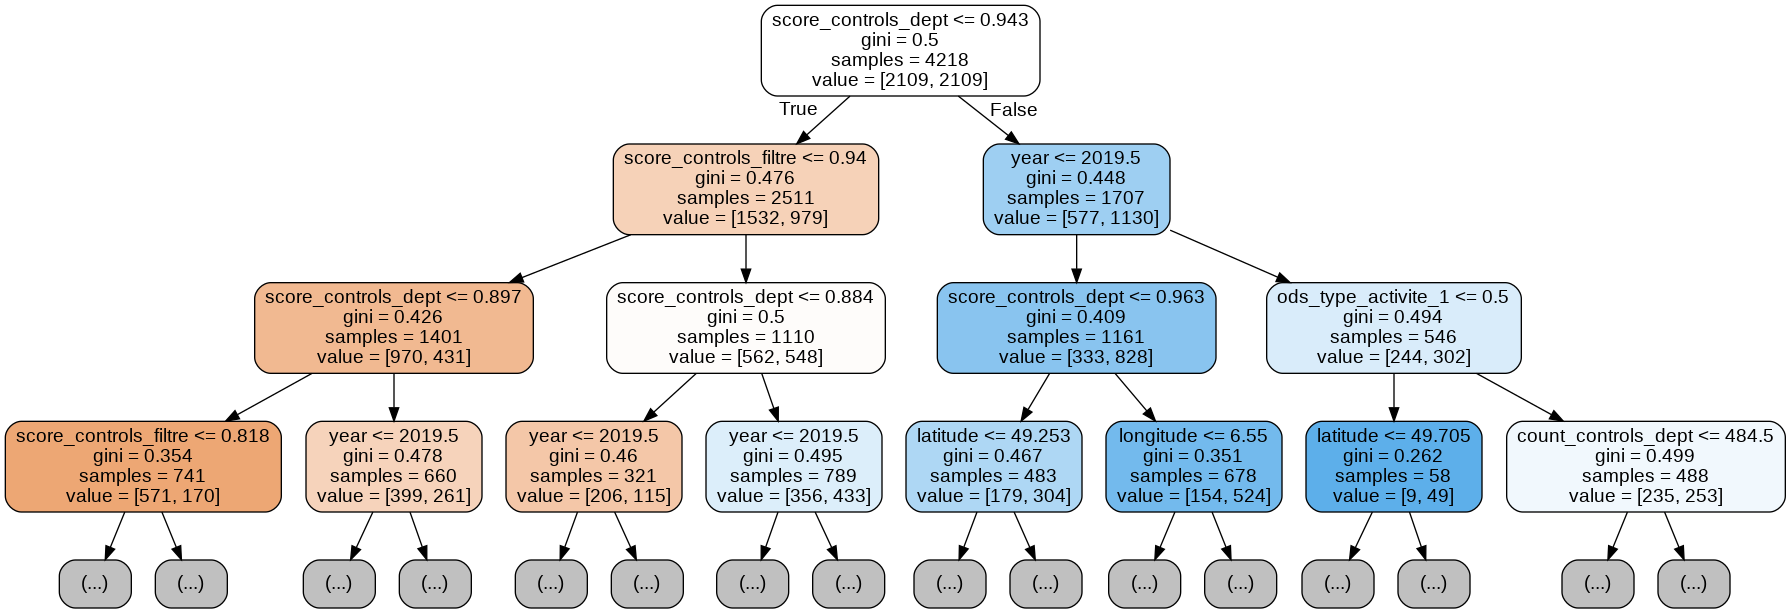

In [46]:
from io import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

def plot_dt(dt, max_depth):
    dot_data = StringIO()
    export_graphviz(dt, out_file=dot_data, filled=True, rounded=True, feature_names=features, max_depth=max_depth)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    return Image(graph.create_png())
    
plot_dt(dt_model, max_depth=3)

### S'appuyer sur un ensemble de modèles

Et si on utilisait plutôt une forêt pleine d'arbres ?

In [47]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, max_depth=12)
rf_model.fit(X_train, y_train)
rf_model.score(X_test, y_test)

0.6882022471910112

### La notion d'hyperparamètres

Le concept d'**hyperparamètres** : des paramètres que le modèle ne peut pas apprendre. Par exemple :
- la profondeur de l'arbre `max_depth`
- le nombre d'arbres dans la forêt `n_estimators`
- le nombre de voisins à considérer `n_neighbors`

Comment les optimiser ? En testant !

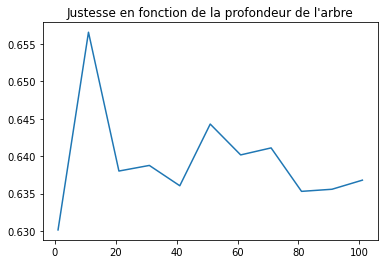

In [48]:
scores = []
steps = range(1, 102, 10)
for n in steps:
  repetitions = range(10)
  step_score = []
  for i in repetitions:
    model = DecisionTreeClassifier(max_depth=n)
    model.fit(X_train, y_train)
    step_score.append(model.score(X_test, y_test))
  scores.append(np.mean(step_score))
plt.plot(steps, scores)
plt.title("Justesse en fonction de la profondeur de l'arbre")
plt.show()

### Les réseaux de neurones

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

nn_model = Sequential([
              Dense(124, name='hidden', activation='relu', input_shape=(len(features),)),
              Dense(1, name='output', activation='sigmoid'),
           ])

nn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
history = nn_model.fit(X_train_norm, y_train, batch_size=200, epochs=100, validation_data=(X_test_norm, y_test))

Epoch 1/100
22/22 [==============================] - 0s 9ms/step - loss: 0.2451 - accuracy: 0.5574 - val_loss: 0.2358 - val_accuracy: 0.6161
Epoch 2/100
22/22 [==============================] - 0s 4ms/step - loss: 0.2302 - accuracy: 0.6299 - val_loss: 0.2247 - val_accuracy: 0.6433
Epoch 3/100
22/22 [==============================] - 0s 4ms/step - loss: 0.2212 - accuracy: 0.6520 - val_loss: 0.2176 - val_accuracy: 0.6489
Epoch 4/100
22/22 [==============================] - 0s 3ms/step - loss: 0.2142 - accuracy: 0.6636 - val_loss: 0.2131 - val_accuracy: 0.6536
Epoch 5/100
22/22 [==============================] - 0s 3ms/step - loss: 0.2097 - accuracy: 0.6709 - val_loss: 0.2126 - val_accuracy: 0.6517
Epoch 6/100
22/22 [==============================] - 0s 3ms/step - loss: 0.2072 - accuracy: 0.6807 - val_loss: 0.2089 - val_accuracy: 0.6601
Epoch 7/100
22/22 [==============================] - 0s 4ms/step - loss: 0.2044 - accuracy: 0.6795 - val_loss: 0.2091 - val_accuracy: 0.6620
Epoch 8/100
2

### La notion d'overfitting

On peut visualiser l'évolution de la performance de lu réseau de neurones au cours de l'entraînement :

[]

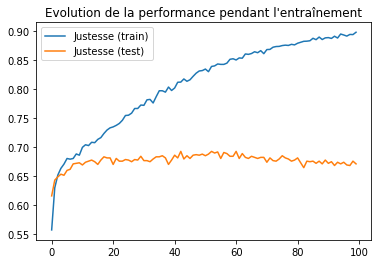

In [51]:
plt.plot(history.history['accuracy'], label='Justesse (train)')
plt.plot(history.history['val_accuracy'], label='Justesse (test)')
plt.title("Evolution de la performance pendant l'entraînement")
plt.legend()
plt.plot()

L'importante notion d'overfitting : lorsque l'algorithme "colle trop" aux données d'entraînement.

## 4. Tester et valider le modèle

On prédit en utilisant le modèle, sur les données de test non vues en entraînement



In [0]:
y_pred = rf_model.predict(X_test)
y_fake = np.random.choice([0, 1], size=len(y_test), p=[1 - y_test.mean(), y_test.mean()])

### Matrice de confusion



In [53]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test, y_pred), index=['Vrai label 0', 'Vrai label 1'], columns=['Label prédit 0', 'Label prédit 1'])

,Label prédit 0,Label prédit 1
Vrai label 0,361,173
Vrai label 1,160,374


### Utiliser différentes métriques

In [54]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

res = []
for metric in [accuracy_score, precision_score, recall_score, f1_score]:
  res.append([metric.__name__, metric(y_test, y_pred), metric(y_test, y_fake)])
pd.DataFrame(res, columns = ['Métrique', 'Score du modèle', "Score de l'aléatoire"])

,Métrique,Score du modèle,Score de l'aléatoire
0,accuracy_score,0.688202,0.479401
1,precision_score,0.683729,0.480357
2,recall_score,0.700375,0.503745
3,f1_score,0.691952,0.491773
